# PCR analysis for the p-value filtered SVI

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, r2_score, mean_absolute_percentage_error
from scipy import stats


## Read and filter the data, based on the kept columns Jose suggested

In [ ]:

df = pd.read_csv("p-value_filtered_SVI.csv")

# get the y values of f-values and weighted f-values from the data
fvalues = df.get("F.values")

wfvalues = df.get("Weighted.f.values")

df2 = pd.read_csv("svi_interactive_map.csv")
testfvalues = pd.read_csv("Filtered_F_Values.csv")
fipsmerge = df2.merge(testfvalues, on='FIPS', how='outer').drop(columns="Unnamed: 0").dropna(subset=['F_VALUE'])
Minn = fipsmerge[fipsmerge['STATE'] == 'Minnesota']
print(fipsmerge)
fips= fipsmerge["FIPS"].apply(str)
fips = pd.DataFrame([s.zfill(5) for s in fips])
fips = fips.rename(columns={0: "FIPS"})
testfvalues = fipsmerge.get("F_VALUE")
fipsmerge.drop(columns=["F_VALUE"])
# drop these columns, as they aren't part of the PCA but rather the outputs for regression
df = df.drop(columns=["F.values", "Weighted.f.values"])
#print(fipsmerge.columns)
# Keeping the columns that Jose mentioned for our analysis
keep = ["E_HH", "EP_POV150", "E_NOHSDP", "E_UNINSUR", "EP_MINRTY", "E_SNGPNT", "E_GROUPQ", "EP_MUNIT", "E_UNEMP", "E_DISABL", "E_TOTPOP", "E_AGE65","E_AGE17", "E_LIMENG", "E_CROWD", "E_NOVEH", "E_DAYPOP" , "E_NOINT"]
keeploc = ["E_HH", "EP_POV150", "E_NOHSDP", "E_UNINSUR", "EP_MINRTY", "E_SNGPNT", "E_GROUPQ", "EP_MUNIT", "E_UNEMP", "E_DISABL", "E_TOTPOP", "E_AGE65","E_AGE17", "E_LIMENG", "E_CROWD", "E_NOVEH", "E_DAYPOP" , "E_NOINT"]
minn_f = Minn["F_VALUE"]
Minn = Minn.drop(columns=["F_VALUE"])
#print(df.columns)
kept = df[keep]
#print(max())
print(fips)

     GEO LEVEL GEO COMPARISON  YEAR GEO UNIT  ST          STATE ST_ABBR  \
245     County       national  2020   county   8       Colorado      CO   
247     County       national  2020   county   8       Colorado      CO   
248     County       national  2020   county   8       Colorado      CO   
251     County       national  2020   county   8       Colorado      CO   
252     County       national  2020   county   8       Colorado      CO   
...        ...            ...   ...      ...  ..            ...     ...   
3041    County       national  2020   county  54  West Virginia      WV   
3043    County       national  2020   county  54  West Virginia      WV   
3044    County       national  2020   county  54  West Virginia      WV   
3045    County       national  2020   county  54  West Virginia      WV   
3046    County       national  2020   county  54  West Virginia      WV   

      STCNTY             COUNTY   FIPS  ...  MP_ASIAN  EP_AIAN  MP_AIAN  \
245     8001       Adams

## Performing the Principal Component Analysis, based on both the Kept Columns Jose suggested and all the columns

In [ ]:
pca1 = PCA(len(keep))
keeping = pca1.fit_transform(scale(kept))
print("% of explained variance in the data for using each number of principal components 1-18 with the kept columns")
expl_var_kept = np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)
print(expl_var_kept)
pca2 = PCA(len(df.columns))
print("% of explained variance in the data for using each number of PCs 1-65 with all cols besides f and weighted f-value.")
all = pca2.fit_transform(scale(df))
expl_var_all = np.cumsum(np.round(pca2.explained_variance_ratio_, decimals=4)*100)
print(expl_var_all)

% of explained variance in the data for using each number of principal components 1-18 with the kept columns
[84.46 92.52 95.88 98.51 99.35 99.75 99.86 99.91 99.94 99.96 99.97 99.98
 99.99 99.99 99.99 99.99 99.99 99.99]
% of explained variance in the data for using each number of PCs 1-65 with all cols besides f and weighted f-value.
[72.03 79.72 84.11 87.62 90.52 92.23 93.58 94.65 95.54 96.16 96.71 97.17
 97.59 97.97 98.28 98.55 98.77 98.96 99.1  99.22 99.33 99.42 99.5  99.58
 99.64 99.7  99.75 99.8  99.83 99.86 99.88 99.9  99.92 99.93 99.94 99.95
 99.96 99.97 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98 99.98
 99.98 99.98 99.98 99.98 99.98 99.98]


### Edit this value to have a certain variance explanation threshold \[0-100%] and choose one of the PCA components set\[kept or all]

In [ ]:
thres = 84.46
components = "kept"

## Constructing the Linear Regression model from the threshold amount, to get the eigenvalues used for calculating the components.

In [ ]:
if components == "kept":
    data = kept
    expl_var = expl_var_kept
else:
    data = df
    expl_var = expl_var_all
print(data["E_UNEMP"])
num_components = 0
for i in range(len(expl_var)):
    if expl_var[i] >= thres:
        num_components = i+1
        break
if num_components == 0:
    num_components = len(expl_var)
#print ("Labels for the components: " + str(list(data.columns)))
#print("Number of components based on threshold (>="+str(thres)+"%): "+str(num_components))
pca = PCA(num_components)
X_train = pca.fit_transform(scale(data))
#print(X_train)

ranked = sorted(zip(list(data.columns), pca.components_.tolist()[0]), key=lambda x: abs(x[1]))
print("Ranked labels of VSIs based on eigenvectors associated with the components constructed for the component analysis:")
print([j[0] for j in ranked][::-1])
print("The eigenvalues: " + str(sorted(pca.components_.tolist()[0], key=lambda x: abs(x))[::-1]))

0      341
1      651
2     1390
3      750
4       64
      ... 
67     353
68    4344
69     147
70     970
71    2010
Name: E_UNEMP, Length: 72, dtype: int64
Ranked labels of VSIs based on eigenvectors associated with the components constructed for the component analysis:
['E_UNEMP', 'E_DAYPOP', 'E_HH', 'E_NOHSDP', 'E_UNINSUR', 'E_DISABL', 'E_TOTPOP', 'E_SNGPNT', 'E_AGE65', 'E_CROWD', 'E_NOINT', 'E_AGE17', 'E_NOVEH', 'E_LIMENG', 'E_GROUPQ', 'EP_MUNIT', 'EP_MINRTY', 'EP_POV150']
The eigenvalues: [0.2558596389132122, 0.2558066925028615, 0.25562193712932424, 0.25556119766646096, 0.2554509224996156, 0.25520876822712507, 0.25518042528753804, 0.2548029875796857, 0.2547132062026891, 0.2545286099794293, 0.25429591645789174, 0.25359342343533325, 0.2523584995615711, 0.25101242262944146, 0.23390847619557212, 0.16803703260605518, 0.09138819874755656, -0.03719193915904962]


## Performing the linear regression based on top VSI1 and plotting + providing correlation coefficient

R^2: -0.5805977329279455
RMSE: 1.2572182519069415
MAPE: 11.157887581186671
      EP_MINRTY
1315        6.3
1317       14.4
1318       28.4
1319       11.1
1320        3.8
...         ...
1395       11.0
1396       18.3
1398        7.1
1399        9.1
1400        8.2

[72 rows x 1 columns]
1315   -0.002853
1317    0.074415
1318    0.111405
1319   -0.005113
1320    0.002779
          ...   
1395   -0.008140
1396   -0.038467
1398    0.000929
1399    0.012733
1400   -0.050212
Name: F_VALUE, Length: 72, dtype: float64


/home/anvitha/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


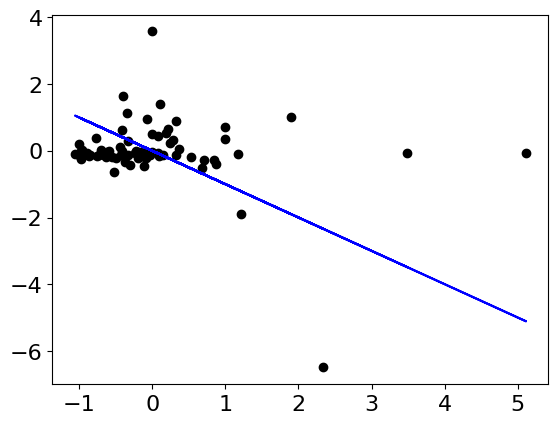

In [ ]:
#train PCR model on training data "E_UNEMP","EP_MINRTY",, "E_UNEMP", "EP_POV150"
indicators = ["EP_MINRTY"]
X1 = Minn[indicators]
#print(keptfipsmerge.columns)
pred = keptfipsmerge.drop(columns=["FIPS"])
#print(fvalues)
train = X1

#print(testfvalues.argmax())
regr1 = LinearRegression()
#print(train)
regr1.fit(scale(train), scale(minn_f))
testfvalues = scale(minn_f)
predfvalues = scale(regr1.predict(train))
#print(fips[0])
#print(r2_score(testfvalues,predfvalues))
# The coefficients
#plt.scatter(trainx, trainy, color="black")
#plt.plot(testx, testy, color="blue", linewidth=3)
#plt.title("Regression with "+ str(indicators) + ", $r^2$ = "+str(r2_score(testfvalues,predfvalues)))
print("R^2: " + str(r2_score(scale(testfvalues),predfvalues)))
#print(scale(regr1.predict(pca.fit_transform(scale(keptfipsmerge)))))
#calculate RMSE
print("RMSE: " + str(np.sqrt(mean_squared_error(testfvalues, predfvalues))))

print("MAPE: " + str(mean_absolute_percentage_error(testfvalues, predfvalues)))
#print(testfvalues)
#print(len())
print(X1)
print(minn_f)
plt.scatter(scale(X1), scale(testfvalues), color="black")
plt.plot(scale(X1), scale(predfvalues), color="blue")
#plt.plot(scale(np.array(keptfipsmerge[indicators])), scale(predfvalues), color="red")


[('EP_POV150', -0.03719193915904962), ('EP_MINRTY', 0.09138819874755656), ('EP_MUNIT', 0.16803703260605518), ('E_GROUPQ', 0.23390847619557212), ('E_LIMENG', 0.25101242262944146), ('E_NOVEH', 0.2523584995615711), ('E_AGE17', 0.25359342343533325), ('E_NOINT', 0.25429591645789174), ('E_CROWD', 0.2545286099794293), ('E_AGE65', 0.2547132062026891), ('E_SNGPNT', 0.2548029875796857), ('E_TOTPOP', 0.25518042528753804), ('E_DISABL', 0.25520876822712507), ('E_UNINSUR', 0.2554509224996156), ('E_NOHSDP', 0.25556119766646096), ('E_HH', 0.25562193712932424), ('E_DAYPOP', 0.2558066925028615), ('E_UNEMP', 0.2558596389132122)]


Text(0.5, 1.0, 'Regression with EP_MINRTY, r = 0.0018693825082197746')

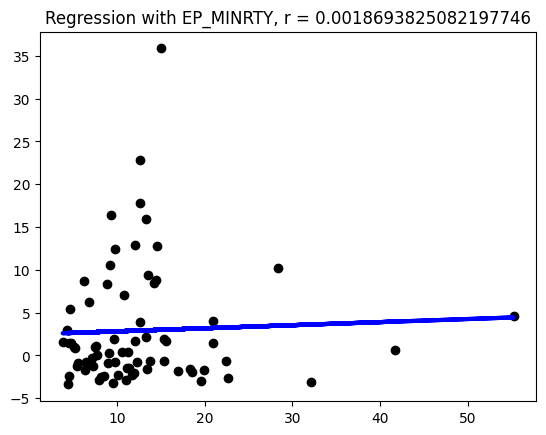

In [ ]:
print("predicted range: "+ str() + " " + str(max(predfvalues)))
print("actual range: "+ str(min(testfvalues)) + " " + str(max(testfvalues)))
predfvalues = scale(predfvalues)
testfvalues = scale(testfvalues)
from scipy.interpolate import interp1d
rangepred = interp1d([min(predfvalues),max(predfvalues)],[-10,10])
rangetest = interp1d([min(testfvalues),max(testfvalues)],[-10,10])
print(pd.DataFrame(testfvalues).apply(lambda x: rangetest(x)))

testf = pd.DataFrame()
testf['FIPS'] = fips
testf['F-VALUES'] = pd.DataFrame(testfvalues).apply(lambda x: rangetest(x))
predf = pd.DataFrame()
predf['FIPS'] = fips
predf['F-VALUES'] =pd.DataFrame(predfvalues).apply(lambda x: rangepred(x))
print(testf)
print(predf)
testf.to_csv("actual_odin.csv", index=False)
predf.to_csv("predicted_odin_all.csv", index=False)


predicted range:  2.5552144455856416
actual range: -4.096694543446702 11.295596776682185
            0
0   -4.908603
1   -5.266564
2   -5.058716
3   -5.225783
4   -5.106533
..        ...
218 -4.675109
219 -4.905054
220 -4.793004
221 -5.026158
222 -3.866160

[223 rows x 1 columns]
      FIPS  F-VALUES
0    08001 -4.908603
1    08005 -5.266564
2    08007 -5.058716
3    08013 -5.225783
4    08014 -5.106533
..     ...       ...
218  54097 -4.675109
219  54101 -4.905054
220  54103 -4.793004
221  54105 -5.026158
222  54107 -3.866160

[223 rows x 2 columns]
      FIPS  F-VALUES
0    08001  5.244688
1    08005  7.011974
2    08007  5.431182
3    08013  7.996372
4    08014  6.097484
..     ...       ...
218  54097  5.140611
219  54101  4.882652
220  54103  5.067982
221  54105  4.987111
222  54107  5.162422

[223 rows x 2 columns]


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)

predict_ = poly.fit_transform(predict)


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.